[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SeoulTechPSE/EngNm/blob/master/ch08_code.ipynb)

In [1]:
# Rendering sympy equations requires MathJax to be available within each cell output. 
# The following is a function that will make this happen for Colab.

#from IPython.display import Math, HTML
#def enable_sympy_in_cell():
#  display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default'></script>"))
#get_ipython().events.register('pre_run_cell', enable_sympy_in_cell)

# Chapter 8: Integration

Creator: Robert Johansson, Updator: Kee-Youn Yoo

Updated source code listings for Numerical Python - A Practical Techniques Approach for Industry (ISBN 978-1-484205-54-9).

## Importing modules

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

from scipy import integrate
import sympy
sympy.init_printing()

## Numerical integration methods

Here we are concerned with evaluating definite integrals on the form $I(f) = \int_a^b f(x) dx$, with given integration limits $a$ and $b$. The interval $[a, b]$ can be finite, semi-infinite (where either $a =-\infty$ or $b=\infty$), or infinite (where $a =-\infty$ and $b=\infty$).

$$ I(f) \approx \sum_{i=0}^{n-1} \omega_i\, f(x_i) +r_n$$

Quadrature rules can be derived from interpolations of $f(x)$ on the interval $[a, b]$. If the points $x_i$ are evenly spaced in the
interval $[a, b]$, and a polynomial interpolation is used, then the resulting quadrature rule is known as a
*Newton-Cotes quadrature rule*.

* For instance, approximating $f(x)$ with a zeroth order polynomial (constant value) using the midpoint value $x_0 = (a + b)/ 2$, we obtain

  $$I(f) \approx f\left(\frac{a +b}{2}\right) \int_a^b dx =(b-a)\, f \left(\frac{a +b}{2}\right)$$

  This is known as the midpoint rule, and it integrates polynomials of up to order one (linear functions)
exactly, and it is therefore said to be of polynomial degree one

* Approximating $f(x)$ by a polynomial of degree one, evaluated at the endpoints of the interval, results in

  $$I(f) \approx \frac{b-a}{2} \left[ f(a) +f(b) \right]$$

  This is known as the trapezoid rule, and it is also of polynomial degree one.

* Using an interpolation polynomial of second order results in *Simpson’s rule*,

  $$I(f) \approx \frac{b-a}{6} \left[ f(a) +4f\left(\frac{a+b}{2} \right)+ f(b) \right]$$

  which uses function evaluations at the endpoints and the midpoint. This method is of polynomial degree three, meaning that it integrates exactly polynomials up to order three.

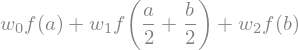

In [3]:
a, b, X = sympy.symbols("a, b, x")
f = sympy.Function("f")

x = a, (a +b)/2, b # for Simpson's rule
w = [sympy.symbols("w_%d" % i) for i in range(len(x))]

q_rule = sum([w[i] *f(x[i]) for i in range(len(x))]); q_rule

To compute the appropriate values of the weight factors $w_i$, we choose the polynomial basis functions
$ \left\{\phi_n(x) = x^n \right\}_{n=0}^2$ for the interpolation of $f(x)$,

In [4]:
phi = [sympy.Lambda(X, X**n) for n in range(len(x))]; phi

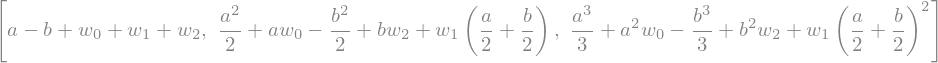

In [5]:
eqs = [q_rule.subs(f, phi[n]) -sympy.integrate(phi[n](X), (X, a, b)) for n in range(len(phi))]; eqs

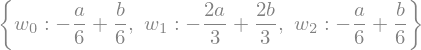

In [6]:
w_sol = sympy.solve(eqs, w); w_sol

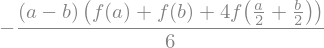

In [7]:
q_rule.subs(w_sol).simplify()

* We recognize this result as Simpson's quadrature rule given above. Choosing different sample points
(the $x$ tuple in this code), results in different quadrature rules.

* Higher-order quadrature rules can similarly be derived using higher-order polynomial interpolation
(more sample points in the $[a, b]$ interval). However, high-order polynomial interpolation can have
undesirable behavior between the sample points. 

* Rather than using higher-order quadrature rules, it is therefore often better to divide the integration interval $[a, b]$ into subintervals $[a=x_0,\,x_1],\,[x_1,\,x_2],\,\cdots,\,[x_{n-1},\,x_n=b]$ and use a low-order quadrature rule in each of these subintervals. Such methods are known as *composite quadrature rules*.

* An important parameter that characterize composite quadrature rules is the sub-interval length
$h =(b - a)/N$. Estimates for the errors in an approximate quadrature rule, and the scaling of the error with
respect to $h$, can be obtained from Taylor series expansions of the integrand and the analytical integration of
the term in the resulting series.

* We have seen that the Newton-Cotes quadrature rules uses evenly spaced sample points of the
integrand $f(x)$. However, this is not necessarily the most efficient choice of quadrature nodes, and
then it can be advantageous to use quadrature rules that do not use evenly spaced sample points. An example of such a method is a *Gaussian quadrature*, which also uses polynomial interpolation to determine the values of the weight factors in the quadrature rule, but where the quadrature nodes $x_i$ are chosen to maximize the order of polynomials that can be integrated exactly (the polynomial degree) given a fixed number of quadrature points.

## Numerical integration with Scipy

The numerical quadrature routines in the Scipy `integrate` module can be categorized into two types:
routines that take the integrand as a Python function, and routines that take arrays with samples of the
integrand at given points.

The functions of the first type use Gaussian quadrature (`quad`, `quadrature`,
`fixed_quad`), while functions of the second type use Newton-Cotes methods (`trapz`, `simps`, and `romb`).

As a concrete example, consider the numerical evaluation of the integral

$$\int_{-1}^1 e^{-x^2} \,dx $$

In [8]:
def f(x):
    return np.exp(-x**2)

val, err = integrate.quad(f, -1, 1)

In [9]:
val, err

### Extra arguments

We wish to evaluate $\displaystyle\int_{-1}^1 a e^{-(x-b)^2/c^2}\, dx$
$\text{ }$for the specific values of the parameters $a =1$, $b = 2$, and $c = 3$,

In [10]:
def f(x, a, b, c):
    return a * np.exp(-((x -b)/c)**2)

val, err = integrate.quad(f, -1, 1, args=(1, 2, 3))

In [11]:
val, err

### Reshuffle arguments

We wish to compute the integral $\displaystyle\int_0^5 J_0 (x)\,dx$, where the integrand $J_0(x)$ is the zero-th order Bessel function of the first kind,

In [12]:
from scipy.special import jv

f = lambda x: jv(0, x)

val, err = integrate.quad(f, 0, 5)

In [13]:
val, err

### Infinite limits

Consider the integral $\displaystyle\int_{-\infty}^{\infty} e^{-x^2} \,dx$,

In [14]:
f = lambda x: np.exp(-x**2)

val, err = integrate.quad(f, -np.inf, np.inf)

In [15]:
val, err

### Singularity

Consider the integral $\displaystyle\int_{-1}^1 \frac{1}{\sqrt{|x|}}\, dx$. 

The integrand diverges at $x = 0$, but the value of the integral does not diverge, and its value is $4$. Naively trying to compute this integral using `quad` may fail because of the diverging integrand:

In [16]:
f = lambda x: 1/np.sqrt(abs(x))

a, b = -1, 1
integrate.quad(f, a, b)

C:\Users\jesuskyr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
C:\Users\jesuskyr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


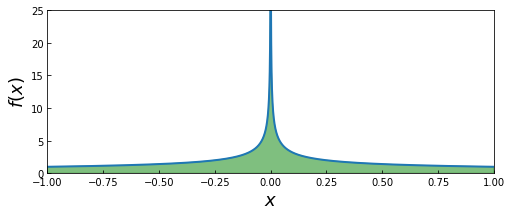

In [17]:
x = np.linspace(a, b, 10000)

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, f(x), lw=2)
ax.fill_between(x, f(x), color='green', alpha=0.5)
ax.set_xlabel("$x$", fontsize=18)
ax.set_ylabel("$f(x)$", fontsize=18)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 25)
ax.tick_params(which='both', direction='in');

In this case, the evaluation of the integral fails because the integrand diverges exactly at one of the
sample points in the Gaussian quadrature rule (the midpoint). We can guide the `quad` routine by specifying
a list of points that should be avoided using the `points` keyword arguments, and using `points=[0]` in the
current example allows `quad` to correctly evaluate the integral:

In [18]:
val, err = integrate.quad(f, a, b, points=[0])

In [19]:
val, err

### Tabulated integrand

Let’s evaluate the integral $\displaystyle\int_0^2 \sqrt{x}\, dx$ by taking $25$ samples of the integrand in the integration interval $[0, 2]$,

In [20]:
f = lambda x: np.sqrt(x)

a, b = 0, 2
x = np.linspace(a, b, 25)
y = f(x)

In [21]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(x, y, 'bo')

xx = np.linspace(a, b, 500)
ax.plot(xx, f(xx), 'b-')
ax.fill_between(xx, f(xx), color='green', alpha=0.5)

ax.set_xlim(0, 2)
ax.set_ylim(0, 1.6)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x)$", fontsize=18)
ax.tick_params(which='both', direction='in')

In [22]:
val_trapz = integrate.trapz(y, x); val_trapz

In [23]:
val_simps = integrate.simps(y, x); val_simps

In [24]:
val_exact = 2.0/3.0 * (b-a)**(3.0/2.0); val_exact

In [25]:
val_exact -val_trapz

In [26]:
val_exact -val_simps

---

In [27]:
x = np.linspace(a, b, 1 + 2**6)
y = f(x)
dx = x[1] - x[0]

val_exact -integrate.romb(y, dx=dx)

In [28]:
val_exact -integrate.simps(y, dx=dx)

## Multiple integration

The double integral routine `dblquad` can evaluate integrals on the form

$$\int_a^b \int_{g(x)}^{h(x)} f(x,y)\, dxdy $$

and it has the function signature `dblquad(f, a, b, g, h)`, where `f` is a Python function for the integrand,
`a` and `b` are constant integration limits along the $x$ dimension, and `g` and `h` are Python functions (taking $x$ as argument) that specify the integration limits along the $y$ dimension.

Consider the integral $\displaystyle\int_0^1 \int_0^1 e^{-(x^2+y^2)}\,dxdy$,

In [29]:
def f(x, y):
    return np.exp(-x**2-y**2)

a, b = 0, 1
g = lambda x: 0
h = lambda x: 1

In [30]:
integrate.dblquad(f, a, b, g, h)

The `tplquad` function can compute integrals on the form

$$ \int_a^b \int_{g(x)}^{h(x)} \int_{q(x,y)}^{r(x,y)} f(x,y,z)\,dxdydz $$

Consider the generalization of the previous integral to three variables: $\displaystyle\int_0^1 \int_0^1 \int_0^1 e^{-(x^2+y^2+z^2)}\,dxdydz$

In [31]:
def f(x, y, z):
    return np.exp(-x**2-y**2-z**2)

a, b = 0, 1
g, h = lambda x: 0, lambda x: 1
q, r = lambda x, y: 0, lambda x, y: 1

integrate.tplquad(f, 0, 1, g, h, q, r)

For arbitrary number of integrations, we can use the `nquad` function.

In [32]:
integrate.nquad(f, [(0, 1), (0, 1), (0, 1)])

In [33]:
def f(*args):
    return  np.exp(-np.sum(np.array(args)**2))

In [34]:
%time integrate.nquad(f, [(0, 1)] * 1)

Wall time: 1 ms


In [35]:
%time integrate.nquad(f, [(0, 1)] * 2)

Wall time: 8 ms


In [36]:
%time integrate.nquad(f, [(0, 1)] * 3)

Wall time: 96 ms


In [37]:
%time integrate.nquad(f, [(0, 1)] * 4)

Wall time: 2.1 s


## Symbolic and arbitrary-precision integration

For example, to compute the integral $\displaystyle\int_{-1}^{1} 2\sqrt{1-x^2}\,dx$, we first create a symbol for $x$, and define expressions for the integrand and the integration

In [38]:
x = sympy.symbols("x")
f = 2 *sympy.sqrt(1 -x**2)
a, b = -1, 1
val_sym = sympy.integrate(f, (x, a, b)); val_sym

As pointed out earlier, this situation is the exception, and in general we will not be able to find an analytical closed-form
expression. We then need to resort to numerical quadrature, for example, using Scipy's `integrate.quad`. However, the `mpmath` library, which comes bundled with Sympy, provides an alternative implementation of numerical quadrature,
using multiple-precision computations. With this library, we can evaluate an integral to arbitrary precision,
without being restricted to the limitations of floating-point numbers.

For example, if we require 75 accurate decimal places, we set:

In [39]:
import mpmath

In [40]:
mpmath.mp.dps = 75
f_mpmath = sympy.lambdify(x, f, 'mpmath')

In [41]:
val = mpmath.quad(f_mpmath, (a, b))
sympy.sympify(val)

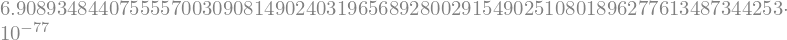

In [42]:
sympy.N(val_sym, mpmath.mp.dps +1) -val

---

In [43]:
%time mpmath.quad(f_mpmath, [a, b])

Wall time: 7 ms


mpf('3.14159265358979323846264338327950288419716939937510582097494459230781640628613')

In [44]:
f_numpy = sympy.lambdify(x, f, 'numpy')
%time integrate.quad(f_numpy, a, b)

Wall time: 999 µs


---

### Double and triple integrals

The `mpmath` library's `quad` function can also be used to evaluate double and triple integrals. 

For example, to compute the double integral:

$$ \int_0^1 \int_0^1 \cos(x) \cos(y)\, e^{-(x^2+y^2)}\, dxdy $$


and the triple integral:

$$ \int_0^1 \int_0^1 \int_0^1 \cos(x) \cos(y) \cos(z)\, e^{-(x^2+y^2+z^2)}\, dx dy dz $$

to 30 significant decimals (this example cannot be solved symbolically with Sympy),

In [45]:
x, y, z = sympy.symbols("x, y, z")

In [46]:
f2 = sympy.cos(x) * sympy.cos(y) * sympy.exp(-x**2 - y**2)
f3 = sympy.cos(x) * sympy.cos(y) * sympy.cos(z) * sympy.exp(-x**2 - y**2 - z**2)

f2_mpmath = sympy.lambdify((x, y), f2, 'mpmath')
f3_mpmath = sympy.lambdify((x, y, z), f3, 'mpmath')

In [47]:
mpmath.mp.dps = 15

res2 = mpmath.quad(f2_mpmath, (0, 1), (0, 1))
res3 = mpmath.quad(f3_mpmath, (0, 1), (0, 1), (0, 1))

In [48]:
sympy.sympify(res2), sympy.sympify(res3)

## Integral transforms

In general, an integral transform of a function $f(t)$ can be written as

$$ T_f(u) = \int_{t_1}^{t_2} \, K(t, u) f(t) \,dt$$

where $T_f(u)$ is the transformed function. The choice of the kernel $K(t, u)$ and the integration limits
determines the type of integral transform. The inverse of the integral transform is given by

$$ f(t)=\int_{u_1}^{u_2} K^{-1}(u, t) \, T_f(u) \, du$$

where $K^{-1} (u,t)$ is the kernel of the inverse transform.

Sympy provides functions for several types of integral transform, but here we focus on the Laplace transform

$$ L_f(s) = \int_0^{\infty} e^{-st} f(t) \,dt $$

with the inverse transform

$$ f(t) = \frac{1}{2\pi i} \int_{\gamma -i\infty}^{\gamma +i \infty} e^{st} L_f(s)\,ds$$

and the Fourier transform

$$ F_f(\omega) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{-i\omega t} f(t)\,dt$$

with the inverse transform

$$ f(t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{i\omega t} F_f(\omega)\,d\omega$$

With Sympy, we can perform these transforms with the `sympy.laplace_transform` and
`sympy.fourier_transform`, respectively, and the corresponding inverse transforms can be computed with
the `sympy.inverse_laplace_transform` and `sympy.inverse_fourier_transform`

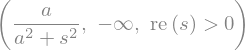

In [49]:
s = sympy.symbols("s")
a, t = sympy.symbols("a, t", positive=True)

f = sympy.sin(a*t)
sympy.laplace_transform(f, t, s)

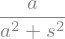

In [50]:
F = sympy.laplace_transform(f, t, s, noconds=True); F

In [51]:
sympy.inverse_laplace_transform(F, s, t, noconds=True)

---

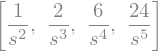

In [52]:
[sympy.laplace_transform(f, t, s, noconds=True) for f in [t, t**2, t**3, t**4]]

In [53]:
n = sympy.symbols("n", integer=True, positive=True)
sympy.laplace_transform(t**n, t, s, noconds=True)

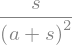

In [54]:
sympy.laplace_transform((1 -a*t) *sympy.exp(-a*t), t, s, noconds=True)

---

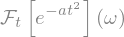

In [55]:
a, t, w = sympy.symbols("a, t, omega")

f = sympy.exp(-a*t**2)
F = sympy.fourier_transform(f, t, w); F

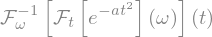

In [56]:
sympy.inverse_fourier_transform(F, w, t)

## Versions

In [57]:
from scipy import __version__
print("numpy: ", np.__version__)
print("sympy: ", sympy.__version__)
print("scipy: ", __version__)
print("matplotlib: ", mpl.__version__)

numpy:  1.18.1
sympy:  1.5.1
scipy:  1.4.1
matplotlib:  3.1.3
